# MLP Model

## Data Import


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import normalize
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
)

In [24]:
df_train = pd.read_csv("dataset/output/no-oversampling/train.csv")
df_test = pd.read_csv("dataset/output/test.csv")

## Data Preparation


In [25]:
# split into X_train, y_train, X_test, y_test
X_train = df_train.drop(columns=["target"])
y_train = df_train["target"]
X_test = df_test.drop(columns=["target"])
y_test = df_test["target"]

# normalize data
X_train = normalize(X_train)
X_test = normalize(X_test)
y_train = normalize(y_train.values.reshape(-1, 1))
y_test = normalize(y_test.values.reshape(-1, 1))

## Helper Functions


In [26]:
# This plots the auc against iteration to detect overfitting
def plot_hist(hist, metric="accuracy"):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

## Model Building


### Base Model


In [27]:
def create_model():
    model = Sequential()
    model.add(Dense(128, input_shape=(X_train.shape[1],), activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1))
    model.compile(
        loss='binary_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy']
    )
    return model

In [28]:
model = create_model()
model.summary()
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               1152      
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 10)                330       
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
Total params: 11,829
Trainable params: 11,829
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
281/281 [==============================] - 1s 2ms/step - loss: 0.6634 - accuracy: 0.6268 - val_loss: 0.6730 - val_accuracy: 0.6650
Epoch 2/100
281/281 [==============================] - 0s 2ms/step - loss: 0.6563 - accuracy: 0.6387 - val_loss: 0.6423 - val_accuracy: 0.6521
Epoch 3/100
281/281 [==============================] - 0s 1ms/step - loss: 0.6533 - accuracy: 0.6408 - val_loss: 0.6492 - val_accuracy: 0.6682
Epoch 4/100
281/281 [==============================] - 0s 1ms/step - loss: 0.6516 - accuracy: 0.6435 - val_loss: 0.6396 - val_accuracy: 0.6699
Epoch 5/100
281/281 [==============================] - 0s 2ms/step - loss: 0.6506 - accuracy: 0.6444 - val_loss: 0.6387 - val_accuracy: 0.6561
Epoch 6/100
281/281 [==============================] - 0s 1ms/step - loss: 0.6495 - accuracy: 0.6443 - val_loss: 0.6341 - val_accuracy: 0.6646
Epoch 7/100
281/281 [==============================] - 0s 1ms/step - loss: 0.6494 - accuracy: 0.6445 - val_loss: 0.6398 - val_accuracy: 0.6543

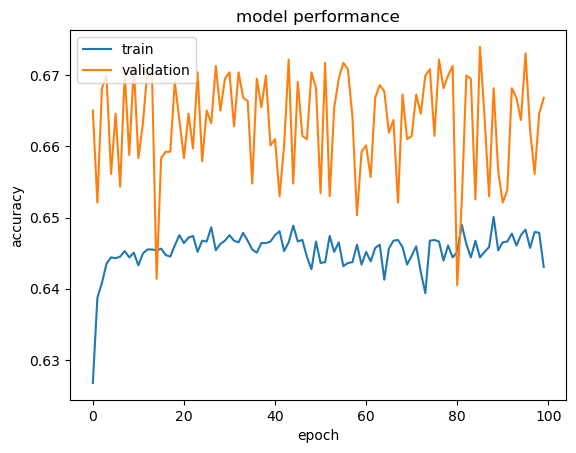

In [29]:
plot_hist(history)

In [43]:
# print confusion matrix and accuracy
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

71/71 [==============================] - 0s 794us/step
Accuracy:  0.6668153434433541

Confusion Matrix: 
 [[1397   49]
 [ 698   98]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.67      0.97      0.79      1446
         1.0       0.67      0.12      0.21       796

    accuracy                           0.67      2242
   macro avg       0.67      0.54      0.50      2242
weighted avg       0.67      0.67      0.58      2242



### Tuned Model


In [38]:
def tune_model(hp):
    units = hp.Choice('units', [128, 256, 512])
    activation = hp.Choice('activation', ['relu', 'tanh'])
    batch_norm = hp.Boolean('batch_norm')
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])
    loss = hp.Choice('loss', ['binary_crossentropy', 'hinge', 'sigmoid_crossentropy', 'mean_squared_error'])

    model = Sequential()
    if units == 512:
        model.add(Dense(units=units, input_shape=(X_train.shape[1],), activation=activation))
        model.add(Dropout(dropout_rate))
        if batch_norm:
            model.add(BatchNormalization())
        
        model.add(Dense(256, activation=activation))
        model.add(Dropout(dropout_rate))
        if batch_norm:
            model.add(BatchNormalization())

        model.add(Dense(128, activation=activation))
        model.add(Dropout(dropout_rate))
        if batch_norm:
            model.add(BatchNormalization())
    elif units == 256:
        model.add(Dense(units=units, input_shape=(X_train.shape[1],), activation=activation))
        model.add(Dropout(dropout_rate))
        if batch_norm:
            model.add(BatchNormalization())

        model.add(Dense(128, activation=activation))
        model.add(Dropout(dropout_rate))
        if batch_norm:
            model.add(BatchNormalization())
    else: 
        model.add(Dense(units=units, input_shape=(X_train.shape[1],), activation=activation))
        model.add(Dropout(dropout_rate))
        if batch_norm:
            model.add(BatchNormalization())


    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_norm:
        model.add(BatchNormalization())

    model.add(Dense(32, activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_norm:
        model.add(BatchNormalization())

    model.add(Dense(10, activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_norm:
        model.add(BatchNormalization())

    model.add(Dense(1))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
tuner = kt.GridSearch(
    tune_model,
    objective='accuracy',
    directory="tuned_models",
    project_name="thyroid_ann_tuning",
    overwrite="true",
)

tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[early_stopping])

Trial 720 Complete [00h 00m 41s]
accuracy: 0.6293560266494751

Best accuracy So Far: 0.6551435589790344
Total elapsed time: 02h 14m 01s
INFO:tensorflow:Oracle triggered exit


In [39]:
best_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]
units = best_hp.get('units')
activation = best_hp.get('activation')
batch_norm = best_hp.get('batch_norm')
dropout_rate = best_hp.get('dropout_rate')
optimizer = best_hp.get('optimizer')
loss = best_hp.get('loss')

print("Best Hyperparameters:")
print(f"Units: {units}")
print(f"Activation: {activation}")
print(f"Batch Normalization: {batch_norm}")
print(f"Dropout Rate: {dropout_rate}")
print(f"Optimizer: {optimizer}")
print(f"Loss: {loss}")
best_model = tuner.hypermodel.build(best_hp)

Best Hyperparameters:
Units: 512
Activation: tanh
Batch Normalization: True
Dropout Rate: 0.0
Optimizer: sgd
Loss: mean_squared_error


In [40]:
best_model.summary()
history = best_model.fit(
    X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 512)               4608      
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                      

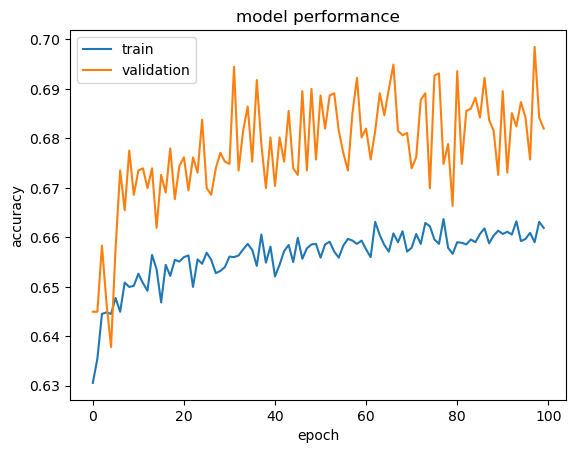

In [41]:
plot_hist(history)

In [42]:
# print confusion matrix and accuracy
y_pred = best_model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix: \n", cm)
print("\nclassification_report: \n", classification_report(y_test, y_pred))

71/71 [==============================] - 0s 1ms/step
Accuracy:  0.6819803746654772

Confusion Matrix: 
 [[1378   68]
 [ 645  151]]

classification_report: 
               precision    recall  f1-score   support

         0.0       0.68      0.95      0.79      1446
         1.0       0.69      0.19      0.30       796

    accuracy                           0.68      2242
   macro avg       0.69      0.57      0.55      2242
weighted avg       0.68      0.68      0.62      2242

